In [ ]:
# TODO:
# stratify continuous target https://michaeljsanders.com/2017/03/24/stratify-continuous-variable.html
# cross validation https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/
# https://stats.stackexchange.com/questions/187335/validation-error-less-than-training-error
# compositional data
# https://wandb.ai/authors/knowledge-distillation/reports/Distilling-Knowledge-in-Neural-Networks--VmlldzoyMjkxODk
# https://stackoverflow.com/questions/37246030/how-to-change-the-temperature-of-a-softmax-output-in-keras
# https://github.com/keras-team/keras/issues/3092
# adaptive learning rate https://keras.io/api/optimizers/learning_rate_schedules/

In [203]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

ImportError: cannot import name 'set_random_seed' from 'tensorflow' (/home/sepidehparhami/.conda/envs/yield/lib/python3.9/site-packages/tensorflow/__init__.py)

In [1]:
import os
print(os.getcwd())
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

/home/sepidehparhami/tutoring/Research Project/yield-prediction


In [102]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv3D, Flatten, Lambda, Activation
from keras.callbacks import History 
import tensorflow as tf

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
yields = pd.read_csv(r'../yield.txt', delim_whitespace=True, index_col=0)

In [5]:
ligands = list(yields.index)

In [6]:
sample_file = pd.read_csv('../data/ESP allPoints_L01-DPPF.txt_interpolated.txt')
sample_file.columns = ('x', 'y', 'z', 'esp')

In [7]:
sample_file.shape

(26999, 4)

In [8]:
sample_file.iloc[-1]

x      13.0
y      14.0
z      14.0
esp     0.0
Name: 26998, dtype: float64

In [9]:
n_molecules = yields.shape[0]
n_coords = sample_file.shape[0]
dim_x, dim_y, dim_z = (len(np.unique(sample_file[data_axis])) for data_axis in ['x','y','z'])

In [10]:
# initialize a data frame and fill in ESPs from file

data = pd.DataFrame(index = ligands, columns=range(n_coords+1))

In [11]:
directory = '../data' 
      
for i,filename in enumerate(os.listdir(directory)):
    # print(i+1,'of',n_molecules)

    data_point = pd.read_csv('../data/{}'.format(filename))
    data_point.columns = ('x', 'y', 'z', 'esp')
    
    # print('number coords in file:',data_point.shape[0])

    #extract the ligand name from the filename
    name_parts = filename.split("_")
    if name_parts[1][0] == "T":
        ligand = name_parts[1][:4]
    else:
        ligand = name_parts[1][:3]
        
    #add label and data point to their respective arrays 
    data.loc[ligand] = data_point['esp']

In [12]:
data[n_coords] = np.zeros(n_molecules,dtype=type(data.iloc[0,0]))

In [13]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,26990,26991,26992,26993,26994,26995,26996,26997,26998,26999
L01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
L06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# turn data frame into 5-dimensional tensror (n_molecules,x,y,z,1 (size of ESP value)) for keras input 
data_arr_5d = np.empty((n_molecules,dim_x,dim_y,dim_z,1),dtype=np.float32)
for i,l in enumerate(ligands):
    data_arr_5d[i] = np.reshape(data.loc[l].values, (dim_x,dim_y,dim_z,1))
# print(data_arr_5d[0])
print(data_arr_5d.shape)

(39, 30, 30, 30, 1)


In [15]:
yields_arr = yields.values
yields_arr[0:2]

array([[83.3,  8.9,  7.9],
       [70.8, 18.4, 10.8]])

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_arr_5d, yields_arr, test_size=0.15,random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(33, 30, 30, 30, 1) (33, 3) (6, 30, 30, 30, 1) (6, 3)


<IPython.core.display.Javascript object>


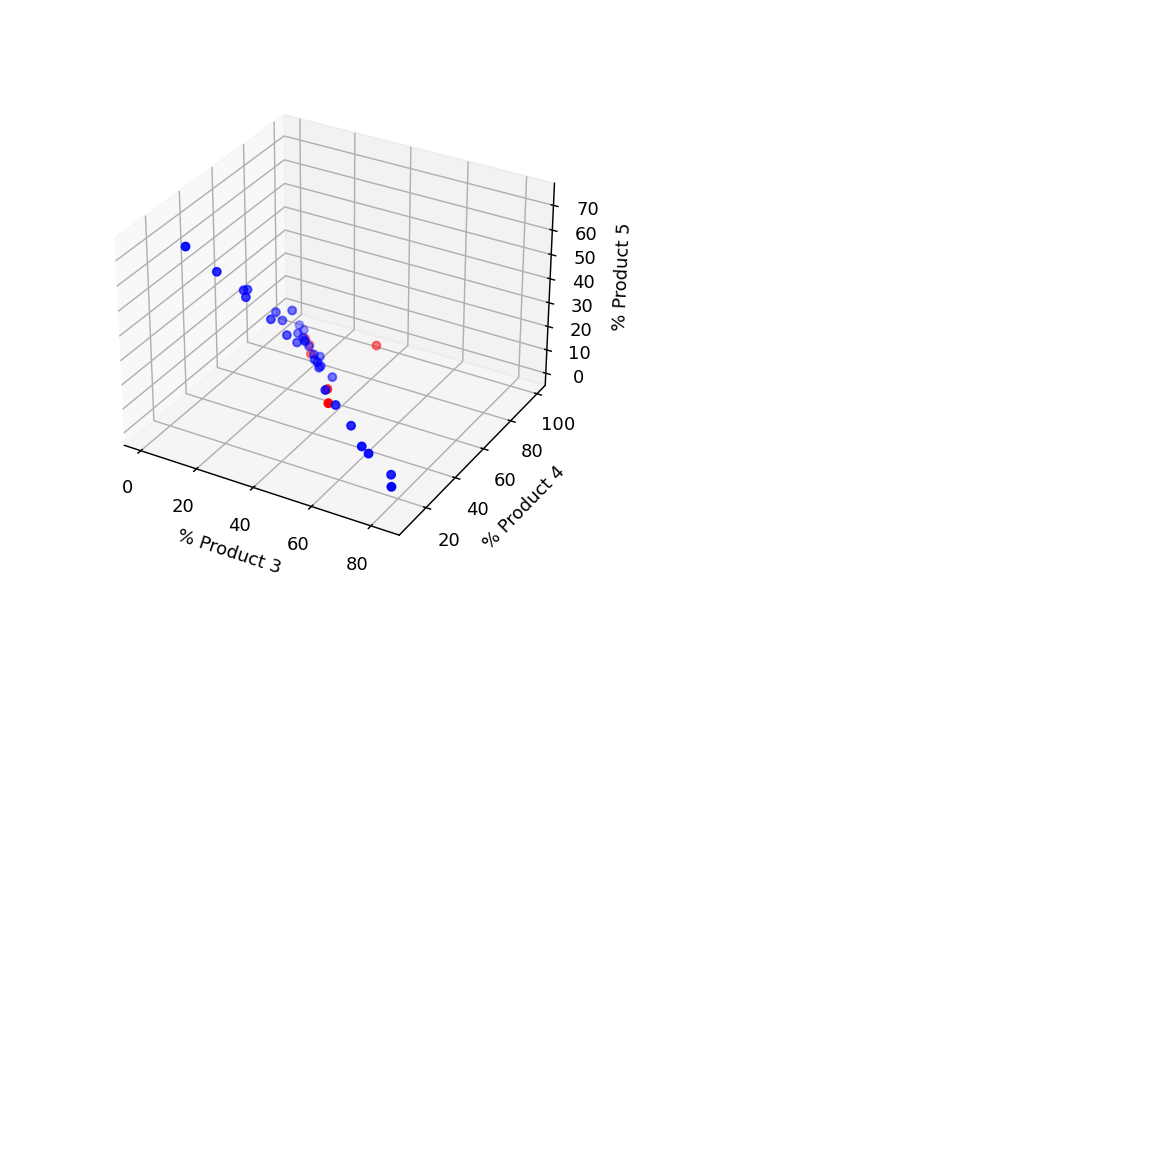

In [17]:
%matplotlib notebook
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(projection='3d')
ax.scatter([x[0] for x in y_train],[x[1] for x in y_train],[x[2] for x in y_train],c='blue')
ax.scatter([x[0] for x in y_test],[x[1] for x in y_test],[x[2] for x in y_test],c='red')
ax.set_xlabel('% Product 3')
ax.set_ylabel('% Product 4')
ax.set_zlabel('% Product 5')

plt.show()

In [18]:
# use tensors for data to be able to use GPU resources
X_train_tensor = tf.convert_to_tensor(X_train)
X_test_tensor = tf.convert_to_tensor(X_test)
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(y_test)

In [234]:
temp = 8
model = Sequential()
model.add(Conv3D(n_molecules,kernel_size=4,activation='relu',input_shape=(dim_x,dim_y,dim_z,1)))
model.add(Conv3D(n_molecules,kernel_size=4,activation='relu',input_shape=(32,32,32,1)))
model.add(Conv3D(n_molecules,kernel_size=4,activation='relu',input_shape=(32,32,32,1)))
model.add(Conv3D(n_molecules,kernel_size=4,activation='relu',input_shape=(32,32,32,1)))
model.add(Flatten())
model.add(Dense(3))
model.add(Lambda(lambda x: x / temp))
model.add(Activation('softmax'))
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-6),loss=loss,metrics=loss)

In [235]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)
model.fit(X_train_tensor,
          y_train_tensor,
          validation_split=0.2,
          callbacks=[earlystop],
          epochs=20)

Epoch 1/20
1/1 [==============================] - 20s 20s/step - loss: 267.8343 - categorical_crossentropy: 267.8343 - val_loss: 110.8554 - val_categorical_crossentropy: 110.8554
Epoch 2/20
1/1 [==============================] - 19s 19s/step - loss: 269.8980 - categorical_crossentropy: 269.8980 - val_loss: 110.8479 - val_categorical_crossentropy: 110.8479
Epoch 3/20
1/1 [==============================] - 20s 20s/step - loss: 271.9690 - categorical_crossentropy: 271.9690 - val_loss: 110.8410 - val_categorical_crossentropy: 110.8410
Epoch 4/20
1/1 [==============================] - 18s 18s/step - loss: 274.0445 - categorical_crossentropy: 274.0445 - val_loss: 110.8341 - val_categorical_crossentropy: 110.8341
Epoch 5/20
1/1 [==============================] - 18s 18s/step - loss: 276.1190 - categorical_crossentropy: 276.1190 - val_loss: 110.8272 - val_categorical_crossentropy: 110.8272


In [236]:
np.set_printoptions(suppress=True)
res = model.predict(X_test)*100
print(res)
print(y_test)

[[66.371666  5.786783 27.84155 ]
 [37.320717 34.085854 28.593428]
 [37.91992  36.007042 26.07303 ]
 [25.042109 39.38704  35.570858]
 [59.011166 17.105648 23.883184]
 [33.046524 33.740505 33.21298 ]]
[[16.2 79.5  4.3]
 [18.9 77.2  3.9]
 [44.1 42.3 13.5]
 [44.3 75.1 13.5]
 [25.7 65.6  8.7]
 [54.  24.4 21.6]]


In [237]:
res_train = model.predict(X_train)*100
print(res_train)
print(y_train)

[[ 14.384315     0.53762656  85.078064  ]
 [ 26.329357    35.1759      38.494743  ]
 [ 32.171494    29.734219    38.09429   ]
 [ 36.03588     30.610731    33.353394  ]
 [ 28.392359    35.799633    35.808     ]
 [ 11.605952    64.498276    23.895777  ]
 [ 13.966529     0.9503654   85.083115  ]
 [ 33.1647      31.692255    35.14305   ]
 [ 42.55593     56.373196     1.0708686 ]
 [  0.00000055   0.00000002 100.        ]
 [  4.610017    82.0841      13.305876  ]
 [ 32.917805    47.306297    19.775898  ]
 [ 14.462212    62.516953    23.020832  ]
 [ 32.60382     29.20109     38.195087  ]
 [ 31.711937    33.295315    34.992744  ]
 [ 32.626736    30.828398    36.54486   ]
 [ 31.252796    33.565327    35.181873  ]
 [ 61.154037    11.563323    27.282629  ]
 [ 29.458385    36.67405     33.867558  ]
 [ 30.586407    35.168285    34.245304  ]
 [ 33.72336     31.5471      34.72954   ]
 [ 33.690964    33.55633     32.752705  ]
 [ 26.52349     31.34748     42.12902   ]
 [ 36.763355    23.437395    39.79

In [67]:
# plot by epoch
print(model.history.history.keys())

# summarize history for accuracy
plt.figure(figsize=(8,8))
plt.plot(np.log2(model.history.history['MSE']))
plt.plot(np.log2(model.history.history['val_MSE']))
plt.title('model log2 MSE')
plt.ylabel('log2 MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(8,8))
plt.plot(np.log2(model.history.history['loss']))
plt.plot(np.log2(model.history.history['val_loss']))
plt.title('model log2 loss')
plt.ylabel('log2 loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

dict_keys([])


KeyError: 'MSE'

<Figure size 576x576 with 0 Axes>

In [26]:
# keras tuner walkthrough https://www.tensorflow.org/tutorials/keras/keras_tuner
import kerastuner as kt

In [27]:
def build_model(hp):
    model = Sequential()
    model.add(Conv3D(hp.Int("units", min_value=32, max_value=1024, step=32),
                     hp.Int("kernel_size", min_value=2, max_value=6, step=1),
                     activation='relu',
                     input_shape=(dim_x,dim_y,dim_z,1)))
    model.add(Flatten())
    model.add(Dense(3))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4])),
        loss='MSE',
        metrics='MSE')
    return model

In [18]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=4,
    overwrite=True)
tuner.search(X_train_tensor, y_train_tensor, epochs=5, validation_split=0.2)

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=4,
    overwrite=True)
tuner.search(X_train_tensor, y_train_tensor, validation_split=0.2)

Epoch 1/2
1/1 [==============================] - 4s 4s/step - loss: 1738.9729 - MSE: 1738.9729 - val_loss: 2101.0828 - val_MSE: 2101.0828
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 1707.0902 - MSE: 1707.090 - 21s 21s/step - loss: 1707.0902 - MSE: 1707.0902 - val_loss: 2101.0828 - val_MSE: 2101.0828


Epoch 1/2
1/1 [==============================] - 18s 18s/step - loss: 1739.7776 - MSE: 1739.7776 - val_loss: 2101.0828 - val_MSE: 2101.0828
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 1707.0905 - MSE: 1707.090 - 55s 55s/step - loss: 1707.0905 - MSE: 1707.0905 - val_loss: 2101.0828 - val_MSE: 2101.0828


Epoch 1/2
1/1 [==============================] - 40s 40s/step - loss: 1737.9358 - MSE: 1737.9358 - val_loss: 2101.0828 - val_MSE: 2101.0828
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 1707.0902 - MSE: 1707.090 - 36s 36s/step - loss: 1707.0902 - MSE: 1707.0902 - val_loss: 2101.0828 - val_MSE: 2101.0828


Epoch 1/2
1/1 [==============================] - 15s 15s/step - loss: 1739.9668 - MSE: 1739.9668 - val_loss: 2101.0828 - val_MSE: 2101.0828
Epoch 2/2
1/1 [==============================] - ETA: 0s - loss: 1707.0905 - MSE: 1707.090 - 59s 59s/step - loss: 1707.0905 - MSE: 1707.0905 - val_loss: 2101.0828 - val_MSE: 2101.0828


Epoch 1/2


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

In [98]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(X_train_tensor, y_train_tensor, epochs=3, validation_split=0.2)
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test MSE]:", eval_result)_tensor

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 2240.7141 - MSE: 2240.714 - 0s 0s/step - loss: 2240.7141 - MSE: 2240.7141 - val_loss: 234698896.0000 - val_MSE: 234698896.0000
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 908121.8750 - MSE: 908121.875 - 0s 51ms/step - loss: 908121.8750 - MSE: 908121.8750 - val_loss: 47583016.0000 - val_MSE: 47583016.0000
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 12248.1328 - MSE: 12248.132 - 0s 0s/step - loss: 12248.1328 - MSE: 12248.1328
[test loss, test MSE]: [12248.1328125, 12248.1328125]


In [99]:
res = hypermodel.predict(X_test)
rowSums = np.sum(res, axis=1)
rowSums = rowSums.reshape((4,1))
print('unnormalized: ', res)
print('normalized: ', res/rowSums * 100)
print('targets: ', y_test)

[[  35.369633    57.799103     6.8312593]
 [  79.81688     -2.322099    22.505215 ]
 [ -48.742283  -156.4174     305.1597   ]
 [ 116.06227     52.019596   -68.08188  ]]
[[32.5 67.4  0.1]
 [75.4 24.4  0.2]
 [16.2 79.5  4.3]
 [70.8 18.4 10.8]]


In [97]:
hypermodel.predict(X_test)

NameError: name 'hypermodel' is not defined

In [24]:
pd.read_csv('/home/sepidehparhami/Diuresis/results/results_final.csv')

,Unnamed: 0,Rsq_train,Rsq_valid,Rsq_test,rmse_train,rmse_valid,rmse_test,regression,train,validation,test,color
0,0,0.884562,0.256122,0.283275,1.964653,5.011416,4.942023,XGBoost,train,validation,test,#949494
1,5,0.857669,0.253774,0.272606,2.181533,5.019319,4.978668,RandomForest,train,validation,test,#ca9161
2,4,0.999714,0.206370,0.235784,0.097816,5.176294,5.103129,KNN,train,validation,test,#cc78bc
3,0,0.224503,0.141476,0.174326,5.092154,5.383763,5.304357,SVR,train,validation,test,#fbafe4
4,2,0.095147,0.096904,0.098206,5.500479,5.521750,5.543475,Lasso,train,validation,test,#029e73
5,3,0.095157,0.096875,0.098171,5.500449,5.521838,5.543584,ElasticNet,train,validation,test,#d55e00
6,0,0.095168,0.096827,0.098084,5.500413,5.521984,5.543849,Ridge,train,validation,test,#0173b2
7,1,0.095168,0.096827,0.098084,5.500413,5.521984,5.543849,LinearRegression,train,validation,test,#de8f05
